In [1]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the TinyStories dataset
dataset = load_dataset("roneneldan/TinyStories")
tokenizer = AutoTokenizer.from_pretrained("gpt2")  # or any suitable tokenizer
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# Preprocess the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])  # Remove original text, keep only tokens
tokenized_datasets.set_format("torch")  # Set format to PyTorch tensors

vocab_size=tokenizer.vocab_size+1


Repo card metadata block was not found. Setting CardData to empty.


In [2]:
import math
from continous_diffusion.diffusion import Diffusion
from continous_diffusion.model import TransformerModel
from continous_diffusion.loss import Loss
from continous_diffusion.embedding import Embedder
from continous_diffusion.scheduling import CauchySchedule, LogisticSchedule
from continous_diffusion.conditioning import TimeConditioning

embed_dim=256
num_heads=8
cond_dim=16
n_blocks=6

dit=TransformerModel(embed_dim,num_heads,cond_dim,n_blocks)
embedder=Embedder(vocab_size,embed_dim)
schedule=CauchySchedule(0.01,20,1,1,math.log(vocab_size),0)
loss=Loss(embedder,schedule)
conditioning=TimeConditioning(cond_dim,cond_dim)
model=Diffusion(dit,loss,conditioning).to('cuda')

In [3]:
# DataLoader
train_loader = DataLoader(tokenized_datasets["train"], batch_size=32, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-3)
# Training loop
model.train()
for epoch in range(1):  # Define num_epochs
    for i,batch in enumerate(train_loader):

        optimizer.zero_grad()  # Define your optimizer
        tokens = batch['input_ids'].to('cuda')
        x,sigma=model.make_sample(tokens)
        prediction=model(x,sigma)
        # Forward pass
        loss = model.loss(tokens,prediction,sigma)

        loss.backward()

        optimizer.step()
        # Log, print, or save as needed
        print(f"Loss: {loss.item()}")



/home/s/github/cdcd/continous_diffusion/DiT_block.py:52: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:264.)
  x=F.scaled_dot_product_attention(q,k,v, scale=1)
/home/s/github/cdcd/continous_diffusion/DiT_block.py:52: UserWarning: 1Torch was not compiled with memory efficient attention. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:320.)
  x=F.scaled_dot_product_attention(q,k,v, scale=1)


Loss: 2.740757942199707
Loss: 2.5720953941345215
Loss: 3.8919522762298584
Loss: 2.106872320175171
Loss: 2.868577480316162
Loss: 3.5205445289611816
Loss: 2.092968463897705
Loss: 2.586263656616211
Loss: 3.0654523372650146
Loss: 2.3508877754211426
Loss: 2.1033005714416504
Loss: 2.955733299255371
Loss: 3.731398582458496
Loss: 1.8191312551498413
Loss: 1.9664825201034546
Loss: 2.8007664680480957
Loss: 1.9931920766830444
Loss: 3.0863661766052246
Loss: 3.1384761333465576
Loss: 2.150693893432617
Loss: 2.5530591011047363
Loss: 2.174537181854248
Loss: 1.5016584396362305
Loss: 2.5606131553649902
Loss: 3.283172130584717
Loss: 3.2202951908111572
Loss: 3.190756320953369
Loss: 2.677851676940918
Loss: 2.280089855194092
Loss: 2.211923360824585
Loss: 2.2096381187438965
Loss: 2.0279741287231445
Loss: 1.7750415802001953
Loss: 2.492668867111206
Loss: 3.3568358421325684
Loss: 2.784271001815796
Loss: 3.187253475189209
Loss: 2.520395040512085
Loss: 2.5377116203308105
Loss: 2.1244611740112305
Loss: 2.3238515853

KeyboardInterrupt: 

TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'

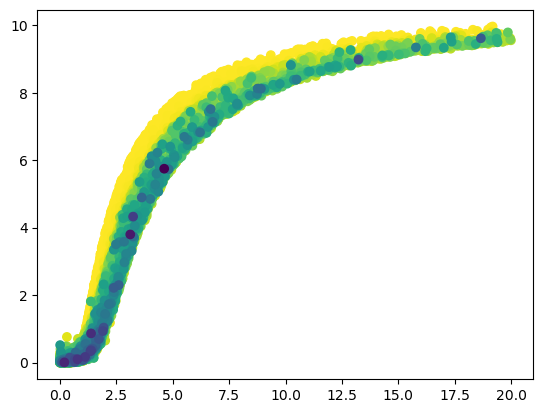

In [4]:
schedule.plot_entropy_time_curve()